In [48]:
import imblearn
import numpy as np
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import sklearn.metrics
from sklearn.metrics import accuracy_score

n_comp = 50

In [18]:
y_path = Path.cwd().parent.joinpath("Data", "Split", "y_train_3cat.npy")
y_train=np.load(y_path)


In [19]:
x_path = Path.cwd().parent.joinpath("Data", "Split", "X_train_3cat.npy") #temperature average of autmn per year
x_train=np.load(x_path)

In [20]:
# Test
print(np.unique(y_train))


[-1.  0.  1.]


In [21]:
random.seed(1234)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(-1.0, 625), (0.0, 625), (1.0, 625)]


In [25]:
temp = x_resampled[:, np.arange(0, 2322)]
pres = x_resampled[:, np.arange(2322, 4644)]

In [30]:
pca= PCA(n_components=n_comp)
temp_trans= pca.fit_transform(temp)
sum(pca.explained_variance_ratio_)
pca_pres=PCA(n_components=n_comp)
pres_trans = pca_pres.fit_transform(pres)
print(pca_pres.explained_variance_ratio_)
print(pca_pres.explained_variance_ratio_.sum())
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pres_trans.shape)
print(temp_trans.shape)
pca_train = np.concatenate([temp_trans, pres_trans], axis=1)

[0.32396272 0.18286659 0.08369375 0.06707524 0.05845859 0.05321015
 0.03146512 0.02617238 0.0209466  0.01683805 0.01483621 0.01394361
 0.01176311 0.01056928 0.00878109 0.00750363 0.00536576 0.00519351
 0.00436283 0.0036514  0.00359991 0.00296476 0.00280353 0.00257388
 0.0023593  0.00222928 0.00210371 0.00181239 0.00155596 0.00139508
 0.00130105 0.00120455 0.00116817 0.00112541 0.00101407 0.00092172
 0.00090929 0.00085133 0.00077027 0.00072939 0.000665   0.0006555
 0.000573   0.00050327 0.00049986 0.00047601 0.00046331 0.00045106
 0.00043742 0.00040184]
0.9891789540574288
[0.14592806 0.0942782  0.08846457 0.07215747 0.05910491 0.04635813
 0.03969103 0.03397051 0.02864779 0.02424478 0.02328634 0.02204857
 0.0175336  0.01667896 0.01573712 0.01472072 0.01273879 0.01226708
 0.01108323 0.01033048 0.00975246 0.00874076 0.00767959 0.00709289
 0.00645556 0.00637758 0.00541833 0.00502915 0.00476623 0.0046127
 0.00447916 0.00416125 0.00409097 0.00382959 0.00365939 0.00329483
 0.00315246 0.0030985

In [60]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
random_grid = {'n_estimators': n_estimators}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(pca_train, y_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [67]:
n_estimators = rf_random.best_params_['n_estimators']
base_model = RandomForestClassifier(n_estimators = n_estimators)
base_model.fit(pca_train, y_resampled)

RandomForestClassifier(n_estimators=400)

In [68]:
scores=cross_val_score(rf, pca_train, y_resampled, cv=2,n_jobs=-1)
scores

array([0.97654584, 0.99039488])

In [70]:
# TEST: 
y_path = Path.cwd().parent.joinpath("Data", "Split", "y_test_3cat.npy")
y_test=np.load(y_path)
x_path = Path.cwd().parent.joinpath("Data", "Split", "X_test_3cat.npy") #temperature average of autmn per year
x_test=np.load(x_path)

# PCA 
temp_test = x_test[:, np.arange(0, 2322)]
pres_test = x_test[:, np.arange(2322, 4644)]
temp_test_tf = pca.transform(temp_test)
pres_test_tf = pca_pres.transform(pres_test)
pca_test = np.concatenate([temp_test_tf, pres_test_tf], axis=1)

In [71]:
pred = base_model.predict(pca_test)
accuracy_score(pred, y_test)
print(pred)
print(y_test)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  1.  0.  0.  0. -1.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
 -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.
  0.  0.  1.  0.  0. -1.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  1. 

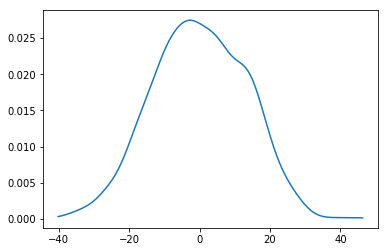

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
data = temp_trans[:,1]
mx = data.max()
mn = data.min()
density = gaussian_kde(data)
xs = np.arange(mn, mx, 0.1)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

[0. 0. 0. ... 1. 1. 1.]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0d39530b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0d3953710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa0d3966f28>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0d3953da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0d38ec128>],
 'means': []}

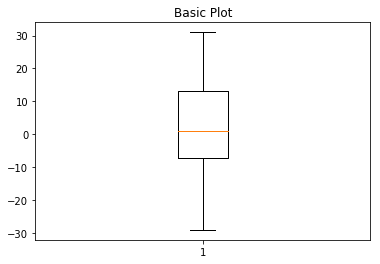

In [89]:
print(y_resampled)
data = temp_trans[y_resampled == -1, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0d3ad7048>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0d3a6e588>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa0d3ad7518>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0d3acd0b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0d3acdc88>],
 'means': []}

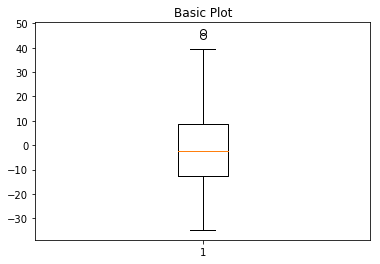

In [90]:
data = temp_trans[y_resampled == 1, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0d3ba5c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0d57dd898>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa0d3ba5898>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0d3c1deb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0d3c1d4e0>],
 'means': []}

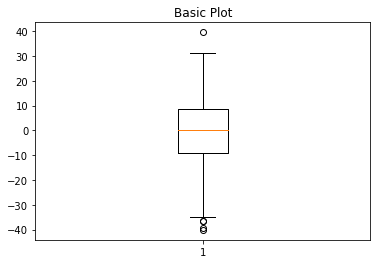

In [91]:
data = temp_trans[y_resampled == 0, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)